In [1]:
import pandas as pd
from core.utils import amino_acid_smiles, amino_acid_symbol
from core.models import AME
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def pred2ic50(pred):
    return (10 ** -pred)*1e9

In [3]:
base_pep = "HHYYRILYGELG"

In [4]:
ame = AME("../config/ame_bio_publish.yml")

Args: {'task': 'ic50_reg_publish', 'sub_type': 'aa', 'data_name': 'bio_reg_publish', 'label_name': 'target', 'peptide_name': 'peptide', 'methods': 'thioether', 'max_workers': 16, 'origin_data_dir': '../data/origin_data', 'graph_data_dir': '../data/graph_data', 'prediction_dir': '../prediction', 'in_feats': 40, 'max_evals': 30, 'loop': True, 'device': 'cuda', 'rgcn_hidden_feats': [64, 64, 64, 64], 'ffn_hidden_feats': 128, 'rgcn_drop_out': 0.05, 'ffn_drop_out': 0.05, 'lr': 0.001, 'mode': 'higher', 'metric_name': 'r2', 'classification': False, 'batch_size': 2048, 'patience': 40}


In [5]:
key_positions = (1, 4, 5, 9)

In [6]:
pred2ic50(ame.predict(seqs=base_pep)[1][0])

  0%|          | 0/1 [00:00<?, ?it/s]

/home/light/mambaforge/envs/sme/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


83.43459988260852

In [29]:
ame.predict(seqs=base_pep)

  0%|          | 0/1 [00:00<?, ?it/s]

([HHYYRILYGELG],
 array([7.078654], dtype=float32),
 array([0.10781673], dtype=float32),
 array([[6.8063912, 6.6745634, 6.6745634, 6.2269516, 6.4261665, 6.707736 ,
         6.831566 , 6.78041  , 6.783629 , 6.8662567, 6.956945 , 6.825952 ,
         6.837487 , 6.8446474, 6.800916 ]], dtype=float32),
 array([[0.08021089, 0.0971251 , 0.0971251 , 0.21371919, 0.05674532,
         0.06569605, 0.04867145, 0.08628022, 0.08596136, 0.09454365,
         0.2461326 , 0.08834867, 0.08304612, 0.08679933, 0.07615065]],
       dtype=float32),
 array([[0.2657289 , 0.38344342, 0.38344342, 0.6919577 , 0.57334197,
         0.35479417, 0.24217935, 0.28970483, 0.28675318, 0.20925978,
         0.12111144, 0.24745665, 0.23659734, 0.2298266 , 0.27080992]],
       dtype=float32))

In [7]:
class Block:
    def __init__(self, base_pep, pos, alter):
        self.base_pep = base_pep
        self.pos = pos
        self.alter = alter

    @property
    def pep(self):
        return self.base_pep[: self.pos] + self.alter + self.base_pep[self.pos + 1 :]

    def __repr__(self) -> str:
        return self.pep

    @property
    def results(self):
        return ame.predict(self.pep, verbose=False)

    def check_std(self):
        if (self.results[2][0] > 0.4) or (self.results[4][0].mean() > 0.4):
            return False
        else:
            return True

    @property
    def color(self):
        if not self.check_std():
            return 0
        return self.results[1][0] - 7.078654

In [8]:
# build blocks
blocks_dict = defaultdict(list)
df_dict = defaultdict(list)
for pos in key_positions:
    print(f"processing pos {pos}")
    for aa in amino_acid_smiles.keys():
        block = Block(base_pep, pos, aa)
        blocks_dict[pos].append(block)
        df_dict[pos].append(block.color)

processing pos 1
processing pos 4
processing pos 5
processing pos 9


In [9]:
data = pd.DataFrame(df_dict)
data.to_csv("./blocks-base.csv")

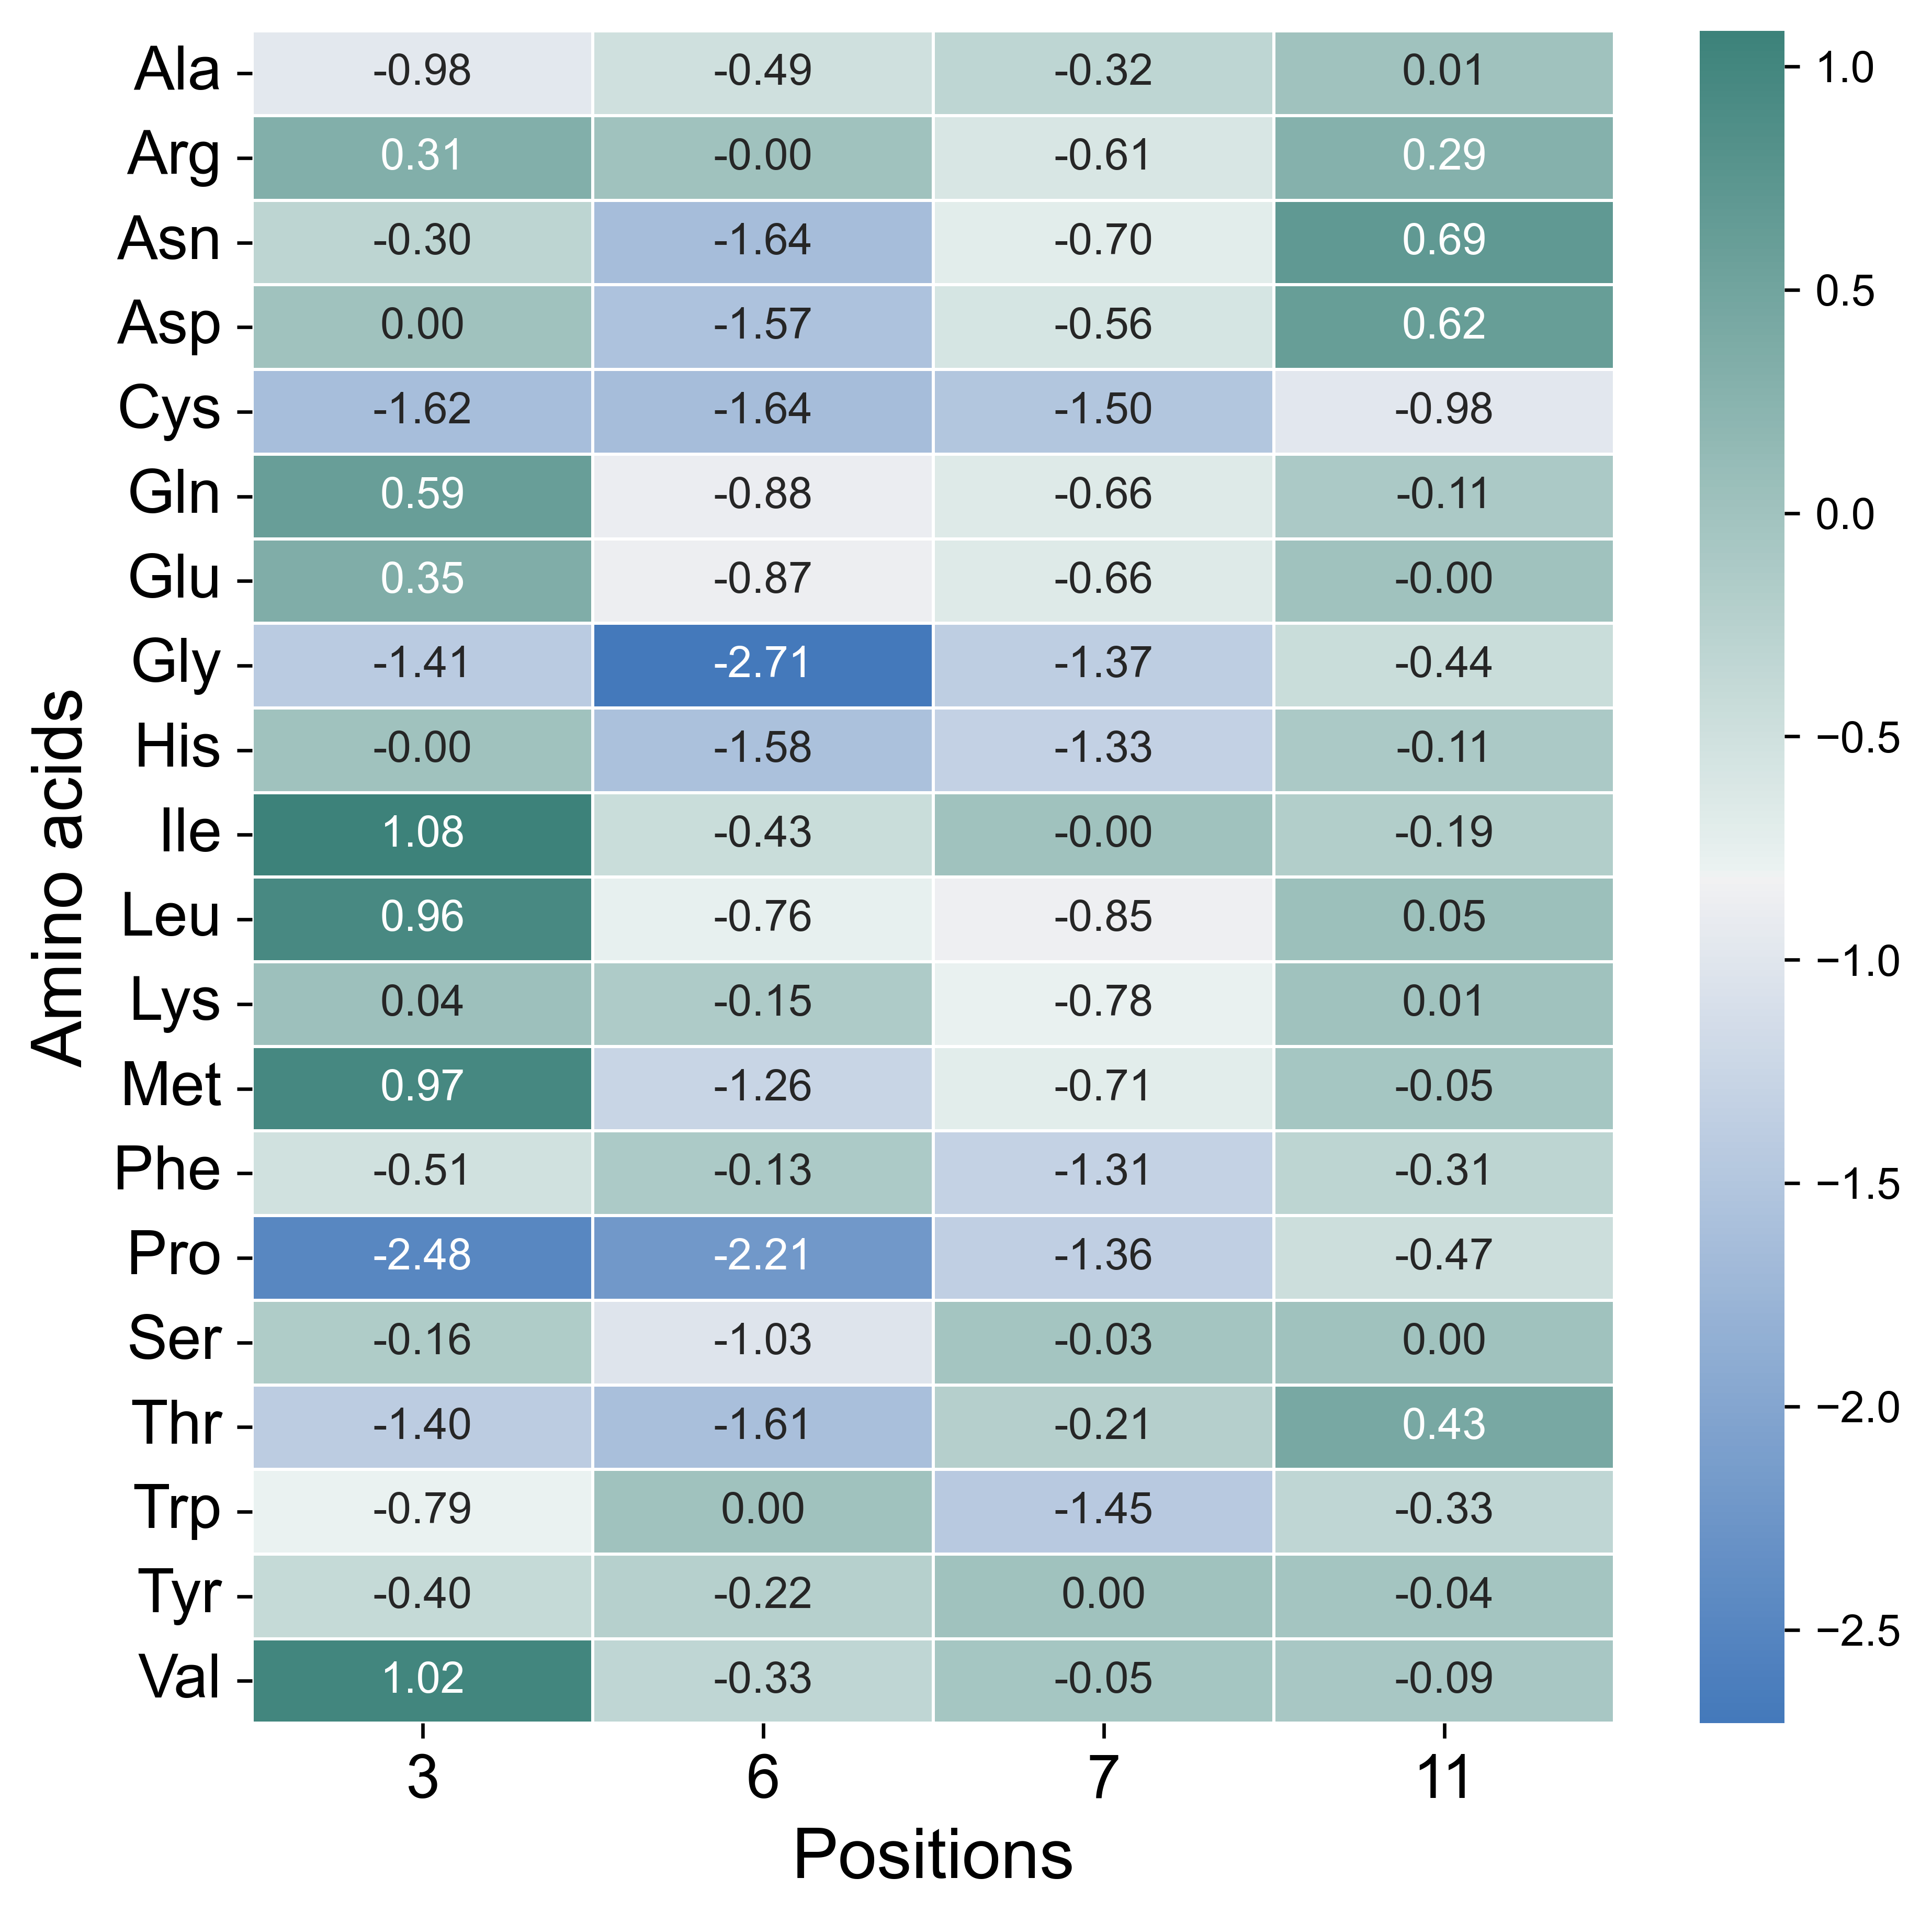

In [10]:
plt.rcParams["figure.dpi"] = 600
plt.rcParams["font.family"] = "arial"

plt.figure(figsize=(7, 7))

# 定义一个自定义的颜色映射，用于突出显示不同的数值
# 220 和 20 是色相值，决定了颜色映射的基本色调
cmap = sns.diverging_palette(250, 180, as_cmap=True)
cmap.set_bad('grey')  # 将数值 0 的颜色设置为灰色

# 将数值为 0 的数据点掩蔽，这样在热图中它们会显示为灰色
data_array_masked = np.ma.masked_where(data == 0, data)

# 创建热图，使用自定义颜色映射
ax = sns.heatmap(data_array_masked, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)

# 设置热图的标题和坐标轴标签
ax.set_xlabel('Positions', fontsize=16)
ax.set_ylabel('Amino acids', fontsize=16)

y_ticks = [x + 0.5 for x in range(len(amino_acid_symbol.values()))]
y_tick_labels = [ x.capitalize() for x in amino_acid_symbol.values() ]
ax.set_yticks(y_ticks, y_tick_labels,  rotation=0, fontsize=14)
ax.set_xticks([0.5, 1.5, 2.5, 3.5], [3, 6, 7, 11], fontsize=14)

# 显示图形
plt.show()

In [11]:
bio_data = pd.read_csv("../data/origin_data/bio_published.csv")
bio_data.head()

,seq,smiles,ic50,label,set
0,HHYYRILYGELG,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)...,166.0,1,train
1,QHYYRILYGELG,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)...,30000.0,0,train
2,HHHYRILYGELG,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)...,6849.0,0,train
3,HHNYRILYGELG,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)...,30000.0,0,train
4,HHYHRILYGELG,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)...,30000.0,0,train


In [12]:
def fetch_ic50(pep):
    if pep in bio_data["seq"].values:
        return bio_data[bio_data["seq"] == pep]["ic50"].values[0]
    else:
        return False
    
def same_sign(a, b):
    return a * b > 0

In [15]:
for k, v in blocks_dict.items():
    for b in v:
        ic50 = fetch_ic50(b.pep)
        if not ic50:
            pass
        else:
            print(ic50, b.pep, b.pos + 2 , b.alter, b.color, pred2ic50(b.results[1][0]),  same_sign(b.color, 166-ic50), sep="|")
            

529.0|HAYYRILYGELG|3|A|-0.9751622168579104|787.9673396638178|True
108.0|HRYYRILYGELG|3|R|0.311577132507324|40.71635267800033|True
15.0|HQYYRILYGELG|3|Q|0.5923102410278318|21.3322055119204|True
86.0|HEYYRILYGELG|3|E|0.35002165155029275|37.26699271214675|True
166.0|HHYYRILYGELG|3|H|-1.875915529581107e-07|83.43459988260852|False
68.0|HLYYRILYGELG|3|L|0.9559271843872068|9.234615459602853|True
89.0|HKYYRILYGELG|3|K|0.03776769952392556|76.48535741432526|True
30000.0|HPYYRILYGELG|3|P|-2.4751221625366213|24915.417134513944|True
119.0|HYYYRILYGELG|3|Y|-0.3955423323669436|207.43800755034954|False
400.0|HHYYAILYGELG|6|A|-0.4902269331970217|257.97221534145535|True
166.0|HHYYRILYGELG|6|R|-1.875915529581107e-07|83.43459988260852|False
2362.0|HHYYNILYGELG|6|N|-1.6355530707397463|3604.948549268799|True
30000.0|HHYYGILYGELG|6|G|-2.708733746246338|42665.785559895914|True
116.0|HHYYKILYGELG|6|K|-0.1476671187438967|117.2230774616627|False
2517.0|HHYYSILYGELG|6|S|-1.025357910827637|884.5123697651572|True
2